# Binary Age Group Classification Using Logistic Regression

This notebook develops a logistic regression classifier to differentiate between two age groups in the BNC2014 corpus:
- **Young**: Speakers aged 0-29 years
- **Old**: Speakers aged 30+ years

The analysis follows these steps:
1. Load the BNC2014 corpus data and speaker metadata
2. Process the corpus to extract speaker-level features
3. Create a binary age classification (young vs. old)
4. Split data into training (80%) and test (20%) sets
5. Train a logistic regression model 
6. Evaluate model performance on the test set
7. Analyze the most informative features

This analysis will help us understand the linguistic differences between age groups and what features are most predictive of a speaker's age group.

In [1]:
# Import required libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import lxml.etree as ET
from wordcloud import WordCloud

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load BNC2014 Corpus Data and Speaker Metadata

First, let's load the corpus data and speaker metadata. This includes speaker demographic information and the text data associated with each speaker.

In [2]:
# Set the path to the dataset
path = 'Dataset'  
dir_corpus = os.path.join(path, 'spoken', 'tagged')
dir_meta = os.path.join(path, 'spoken', 'metadata')

# Load speaker metadata
fields_s = pd.read_csv(
    os.path.join(dir_meta, 'metadata-fields-speaker.txt'),
    sep='\t', skiprows=1, index_col=0
)

# Load the speaker metadata
df_speakers_meta = pd.read_csv(
    os.path.join(dir_meta, 'bnc2014spoken-speakerdata.tsv'),
    sep='\t', names=fields_s['XML tag'], index_col=0
)

print(f"Loaded metadata for {len(df_speakers_meta)} speakers")
print("\nSample of speaker metadata:")
print(df_speakers_meta.head())

Loaded metadata for 671 speakers

Sample of speaker metadata:
      exactage  age1994 agerange gender      nat  \
S0001       32    25_34    30_39      F  British   
S0002      NaN  Unknown    19_29      F  British   
S0003      NaN  Unknown    19_29      F  British   
S0004      NaN  Unknown    30_39      M  British   
S0005      NaN   60plus    80_89      F  British   

                               birthplace birthcountry       l1 lingorig  \
S0001             Wordsley, West Midlands      England  English  England   
S0002                          Birmingham      England  English  England   
S0003  Royal Leamington Spa, Warwickshire      England  English  England   
S0004                                 NaN      Germany  English  England   
S0005                          Birmingham      England  English  England   

          dialect_rep  ...   dialect_l2   dialect_l3   dialect_l4  \
S0001  None indicated  ...  unspecified  unspecified  unspecified   
S0002        Midlands  ...    

Age range distribution:
agerange
0_10         7
11_18       42
19_29      250
30_39       89
40_49       76
50_59       77
60_69       65
70_79       33
80_89       19
90_99        4
Unknown      9
Name: count, dtype: int64


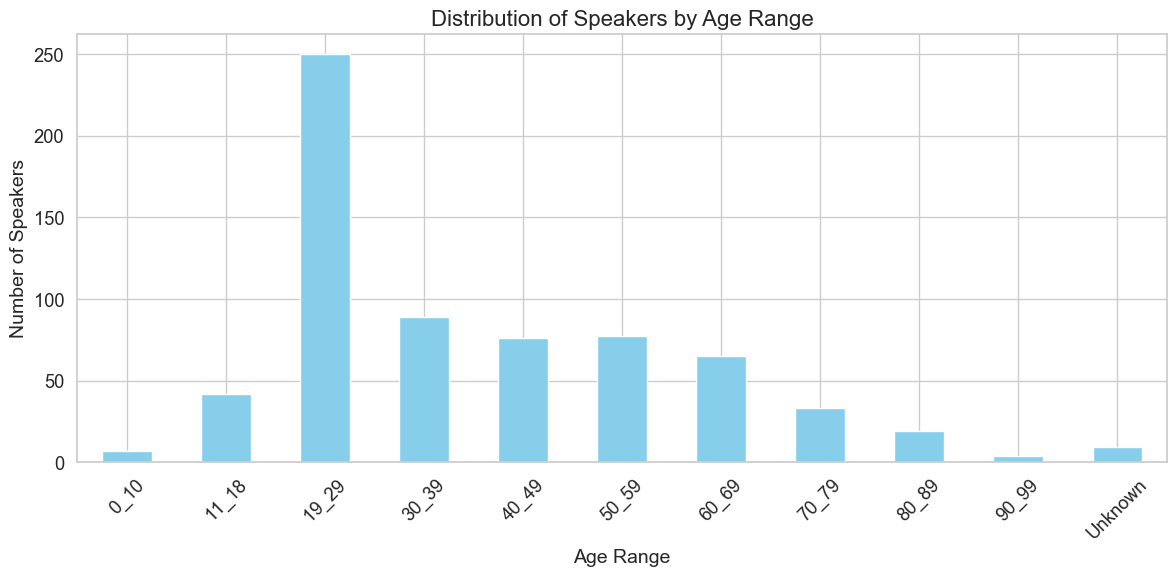

In [3]:
# Check the distribution of age ranges in the metadata
print("Age range distribution:")
age_counts = df_speakers_meta['agerange'].value_counts().sort_index()
print(age_counts)

# Visualize age distribution
plt.figure(figsize=(12, 6))
age_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Speakers by Age Range', fontsize=16)
plt.xlabel('Age Range', fontsize=14)
plt.ylabel('Number of Speakers', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Create Binary Age Groups

We'll divide speakers into two age categories:
- **Young**: Speakers aged 0-29 years (combining age ranges 0-18 and 19-29)
- **Old**: Speakers aged 30+ years (combining age ranges 30-59 and 60+)

Distribution of speakers by binary age classification:
binary_age
Young    388
Old      274
Name: count, dtype: int64
Percentage: Old 41.4%, Young 58.6%


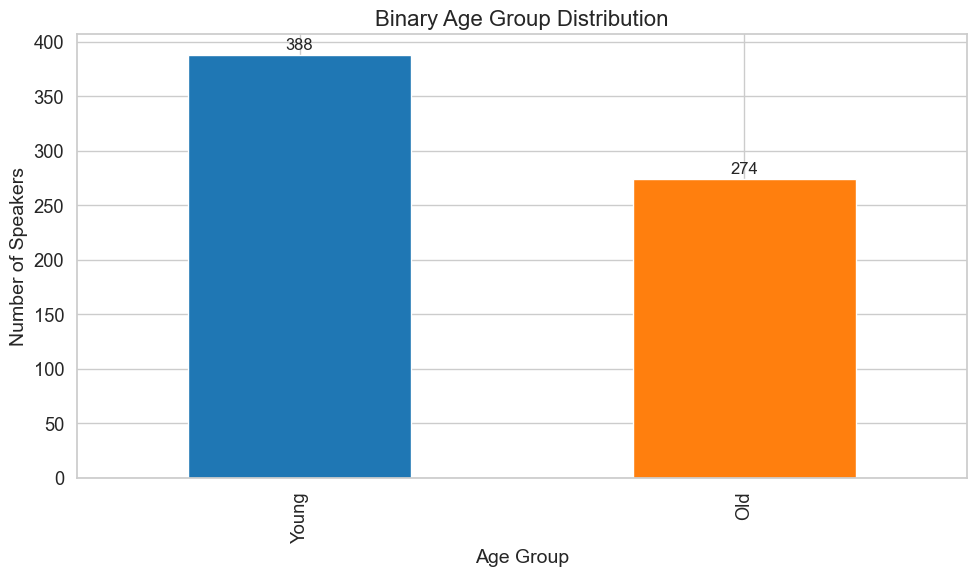


Example speakers in 'Young' group:
      gender agerange binary_age      edqual
S0001      F    30_39      Young  5_postgrad
S0002      F    19_29      Young  5_postgrad
S0003      F    19_29      Young  4_graduate

Example speakers in 'Old' group:
      gender agerange binary_age       edqual
S0005      F    80_89        Old  2_secondary
S0006      M    80_89        Old  3_sixthform
S0008      M    60_69        Old   4_graduate


In [58]:
# Function to map BNC age ranges to binary categories
def map_to_binary_age(age_range):
    """
    Map BNC age ranges to binary categories:
    Young (0-29) vs Old (30+)
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC metadata (e.g., '0_18', '19-29', '30_59', '60_plus')
        
    Returns:
    --------
    str
        'Young' or 'Old' classification
    """
    if pd.isna(age_range) or age_range == 'Unknown':
        return np.nan
    
    # Handle different formats in the age range field
    try:
        # Extract the upper bound of the age range
        if '_' in str(age_range):
            ages = str(age_range).split('_')
        elif '-' in str(age_range):
            ages = str(age_range).split('-')
        else:
            # Silently skip unknown formats without printing
            return np.nan
        
        # Parse the upper bound
        if ages[1] == 'plus':
            upper = 100  # Arbitrarily high for '60_plus'
        else:
            upper = int(ages[1])
        
        # Classify as young or old
        if upper <= 39:
            return "Young"
        else:
            return "Old"
    except Exception as e:
        # Silently return np.nan for any errors
        return np.nan

# Apply the binary age classification to speaker metadata
df_speakers_meta['binary_age'] = df_speakers_meta['agerange'].apply(map_to_binary_age)

# Display the counts for each binary age group
binary_age_counts = df_speakers_meta['binary_age'].value_counts()
print("Distribution of speakers by binary age classification:")
print(binary_age_counts)

# Calculate percentages separately to avoid formatting error
percentages = 100 * binary_age_counts / binary_age_counts.sum()
print(f"Percentage: Old {percentages['Old']:.1f}%, Young {percentages['Young']:.1f}%")

# Visualize the binary age distribution
plt.figure(figsize=(10, 6))
ax = binary_age_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Binary Age Group Distribution', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Speakers', fontsize=14)

# Add count labels on top of bars
for i, count in enumerate(binary_age_counts):
    ax.text(i, count + 5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Show examples of speakers in each binary age group
print("\nExample speakers in 'Young' group:")
young_examples = df_speakers_meta[df_speakers_meta['binary_age'] == 'Young'].head(3)
print(young_examples[['gender', 'agerange', 'binary_age', 'edqual']])

print("\nExample speakers in 'Old' group:")
old_examples = df_speakers_meta[df_speakers_meta['binary_age'] == 'Old'].head(3)
print(old_examples[['gender', 'agerange', 'binary_age', 'edqual']])

## 3. Load and Process Corpus Text Data

Now, we'll load the corpus text data and extract features for each speaker, including:
- Word usage patterns
- Lexical diversity
- Part-of-speech usage
- Sentence structure features

In [59]:
# Process tagged corpus files to extract word and linguistic feature data
# Process all available files in the corpus
corpus_files = sorted(os.listdir(dir_corpus))
file_count_total = len(corpus_files)
print(f"Found {file_count_total} files in the corpus directory")

tagged_rows = []
try:
    # Load all corpus files
    for file_count, fname in enumerate(corpus_files):
        # Print progress every 5 files
        if file_count % 5 == 0:
            print(f"Processing file {file_count+1}/{file_count_total}: {fname}")
            
        fpath = os.path.join(dir_corpus, fname)
        xml = ET.parse(fpath)
        root = xml.getroot()
        text_id = root.get('id')
        
        for u in root.findall('.//u'):
            utt_id = u.get('n')
            spk = u.get('who')
            for w in u.findall('w'):
                tagged_rows.append({
                    'text_id': text_id,
                    'utterance_id': utt_id,
                    'speaker_id': spk,
                    'word': w.text,
                    'lemma': w.get('lemma'),
                    'pos': w.get('pos'),
                    'class': w.get('class'),
                    'usas': w.get('usas'),
                })
    
    # Create a DataFrame from the extracted data
    df_tagged = pd.DataFrame(tagged_rows)
    
    print(f"\nLoaded {len(df_tagged)} word tokens from {file_count_total} files")
    print(f"Found {df_tagged['speaker_id'].nunique()} unique speakers in the processed data")
    
except Exception as e:
    print(f"Error loading corpus data: {e}")

Found 1251 files in the corpus directory
Processing file 1/1251: S23A-tgd.xml
Processing file 6/1251: S26N-tgd.xml
Processing file 11/1251: S2A5-tgd.xml
Processing file 16/1251: S2CY-tgd.xml
Processing file 21/1251: S2FT-tgd.xml
Processing file 26/1251: S2K6-tgd.xml
Processing file 31/1251: S2NQ-tgd.xml
Processing file 36/1251: S2T6-tgd.xml
Processing file 41/1251: S2UT-tgd.xml
Processing file 46/1251: S2YK-tgd.xml
Processing file 51/1251: S33B-tgd.xml
Processing file 56/1251: S35U-tgd.xml
Processing file 61/1251: S37K-tgd.xml
Processing file 66/1251: S38V-tgd.xml
Processing file 71/1251: S3C6-tgd.xml
Processing file 76/1251: S3JF-tgd.xml
Processing file 81/1251: S3MW-tgd.xml
Processing file 86/1251: S3RZ-tgd.xml
Processing file 91/1251: S3TZ-tgd.xml
Processing file 96/1251: S3YZ-tgd.xml
Processing file 101/1251: S457-tgd.xml
Processing file 106/1251: S47C-tgd.xml
Processing file 111/1251: S4C2-tgd.xml
Processing file 116/1251: S4K7-tgd.xml
Processing file 121/1251: S4MV-tgd.xml
Proces

In [60]:
# Explore the corpus data
print("Sample of word-level data:")
print(df_tagged.head())

# Count of speakers with valid age data
valid_age_speakers = set(df_speakers_meta[~df_speakers_meta['binary_age'].isna()].index)
tagged_speakers = set(df_tagged['speaker_id'].unique())
valid_speakers = valid_age_speakers.intersection(tagged_speakers)

print(f"\nOf {len(tagged_speakers)} speakers in the corpus data, {len(valid_speakers)} have valid age data")

# Filter to only include speakers with valid age data
df_tagged_valid = df_tagged[df_tagged['speaker_id'].isin(valid_speakers)]
print(f"Filtered corpus data contains {len(df_tagged_valid)} word tokens from {len(valid_speakers)} speakers")

Sample of word-level data:
  text_id utterance_id speaker_id   word lemma   pos  class  usas
0    S23A            1      S0094  words  word   NN2  SUBST    Q3
1    S23A            2      S0095     it    it  PPH1   PRON    Z8
2    S23A            2      S0095     's    be   VBZ   VERB    A3
3    S23A            2      S0095      a     a   AT1    ART    Z5
4    S23A            2      S0095  games  game   NN2  SUBST  K5:1

Of 671 speakers in the corpus data, 662 have valid age data
Filtered corpus data contains 11181155 word tokens from 662 speakers


## 4. Feature Engineering

Now let's create features for each speaker that we'll use for classification. We'll extract:
1. Word usage patterns (bag of words)
2. Part-of-speech distribution
3. Lexical diversity measures
4. Other linguistic features

In [61]:
# Create speaker-level features
def create_speaker_features(df_tagged, df_speakers_meta):
    """
    Create a dataframe of speaker-level features for classification
    
    Parameters:
    -----------
    df_tagged : pd.DataFrame
        DataFrame with word-level corpus data
    df_speakers_meta : pd.DataFrame
        DataFrame with speaker metadata
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with speaker-level features
    """
    # Dictionary to store features for each speaker
    speaker_features = {}
    
    # Group by speaker_id
    for speaker_id, speaker_data in df_tagged.groupby('speaker_id'):
        if speaker_id not in df_speakers_meta.index:
            continue
            
        # Extract words and texts for this speaker
        words = speaker_data['word'].tolist()
        lemmas = speaker_data['lemma'].fillna('').tolist()
        pos_tags = speaker_data['pos'].fillna('').tolist()
        word_classes = speaker_data['class'].fillna('').tolist()
        
        # Skip speakers with too few words (< 50)
        if len(words) < 50:
            continue
            
        # Dictionary for this speaker's features
        features = {}
        
        # 1. Basic counts
        features['total_words'] = len(words)
        features['unique_words'] = len(set([w.lower() for w in words if w]))
        features['unique_lemmas'] = len(set([l.lower() for l in lemmas if l]))
        
        # 2. Lexical diversity (type-token ratio)
        features['lexical_diversity'] = features['unique_words'] / features['total_words']
        features['lemma_diversity'] = features['unique_lemmas'] / features['total_words']
        
        # 3. Part-of-speech distributions
        pos_counter = Counter(pos_tags)
        total_pos = sum(pos_counter.values())
        
        # Add normalized POS features (as percentages)
        for pos, count in pos_counter.most_common():
            if pos:  # Skip empty POS tags
                features[f'pos_{pos}'] = count / total_pos
                
        # 4. Word class distributions
        class_counter = Counter(word_classes)
        total_classes = sum(class_counter.values())
        
        # Add normalized word class features
        for wclass, count in class_counter.most_common():
            if wclass:  # Skip empty class tags
                features[f'class_{wclass}'] = count / total_classes
        
        # 5. Calculate average word length
        word_lengths = [len(w) for w in words if w]
        features['avg_word_length'] = sum(word_lengths) / len(word_lengths) if word_lengths else 0
        
        # 6. Count specific linguistic markers
        
        # Filler words and discourse markers
        filler_words = ['um', 'uh', 'er', 'erm', 'like', 'you know', 'i mean', 'well', 'so']
        filler_count = sum(1 for w in words if w and w.lower() in filler_words)
        features['filler_ratio'] = filler_count / features['total_words']
        
        # Store features for this speaker
        speaker_features[speaker_id] = features
    
    # Create DataFrame from features dictionary
    features_df = pd.DataFrame.from_dict(speaker_features, orient='index')
    
    # Add binary age from metadata
    features_df = features_df.join(
        df_speakers_meta[['binary_age', 'gender', 'edqual']], 
        how='left'
    )
    
    # Drop rows with missing binary_age
    features_df = features_df.dropna(subset=['binary_age'])
    
    return features_df

# Create speaker features dataframe
speakers_df = create_speaker_features(df_tagged_valid, df_speakers_meta)

print(f"Created feature dataframe with {len(speakers_df)} speakers")
print(f"Feature dataframe has {speakers_df.shape[1]} columns")

# Show some sample speakers with their features
print("\nSample of speaker features:")
print(speakers_df.head())

# See the distribution of binary_age in the feature dataset
print("\nDistribution of binary age groups in feature dataset:")
age_distribution = speakers_df['binary_age'].value_counts()
print(age_distribution)

# Calculate percentages separately to avoid formatting error
age_percentages = 100 * age_distribution / age_distribution.sum()
print(f"Percentage: Old {age_percentages['Old']:.1f}%, Young {age_percentages['Young']:.1f}%")

Created feature dataframe with 658 speakers
Feature dataframe has 274 columns

Sample of speaker features:
       total_words  unique_words  unique_lemmas  lexical_diversity  \
S0001         2890           673            588           0.232872   
S0002         8481          1161            978           0.136894   
S0003         1876           406            360           0.216418   
S0004         3626           888            767           0.244898   
S0005         1438           346            303           0.240612   

       lemma_diversity   pos_NN1    pos_RR    pos_UH    pos_JJ    pos_II  ...  \
S0001         0.203460  0.087543  0.067128  0.056401  0.048789  0.041176  ...   
S0002         0.115317  0.071925  0.065676  0.035373  0.043391  0.043155  ...   
S0003         0.191898  0.073028  0.042111  0.055437  0.038913  0.049041  ...   
S0004         0.211528  0.106729  0.044677  0.033646  0.041368  0.048538  ...   
S0005         0.210709  0.073018  0.033380  0.054937  0.031989  0.0

In [62]:
# Create a text corpus for each speaker for bag-of-words features
# Combine all words from each speaker into a single document
speaker_texts = {}

for speaker_id, speaker_data in df_tagged_valid.groupby('speaker_id'):
    if speaker_id in speakers_df.index:
        words = speaker_data['lemma'].fillna('').tolist()
        # Convert to lowercase and join with spaces
        speaker_texts[speaker_id] = ' '.join([w.lower() for w in words if w])

# Create a Series with speaker_id as index and text as values
speaker_corpus = pd.Series(speaker_texts)

# Display the first few speaker texts
print(f"Created text corpus for {len(speaker_corpus)} speakers")
print("\nSample speaker texts:")
for speaker_id, text in list(speaker_corpus.items())[:2]:
    print(f"\nSpeaker {speaker_id}:")
    print(text[:200] + "...")  # Show first 200 characters

Created text corpus for 658 speakers

Sample speaker texts:

Speaker S0001:
mm sit around drinking tea watch small child play with toy there be some of that mm that be your godmother 's dog be not it punc she be like stay at --anonnamem 's parent over christmas as well and er...

Speaker S0002:
yes unfortunately i mean fortunately er oh do i say that punc yes it be just a lesser hovel two flatmate but they be quite quiet they be third year undergrad so they be about to finish and they have g...


## 5. Prepare Data for Classification

Now we'll prepare our data for the logistic regression classifier. We'll:
1. Encode the target variable
2. Split the data into training and test sets (80% train, 20% test)
3. Create a TF-IDF vectorizer for text features
4. Scale numerical features

In [63]:
# Encode the target variable (binary_age)
speakers_df['age_label'] = (speakers_df['binary_age'] == 'Old').astype(int)

# Verify encoding
print("Binary age encoding:")
print(speakers_df[['binary_age', 'age_label']].drop_duplicates())

# Get features and target
X_features = speakers_df.drop(['binary_age', 'age_label', 'gender', 'edqual'], axis=1)
y = speakers_df['age_label']

# Check for and handle NaN values
print(f"Features with NaN values: {X_features.isna().any().sum()} out of {X_features.shape[1]}")
if X_features.isna().any().any():
    print("Imputing missing values...")
    # Use simple imputation with mean strategy
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_features_imputed = pd.DataFrame(
        imputer.fit_transform(X_features),
        columns=X_features.columns,
        index=X_features.index
    )
    print("Imputation complete.")
else:
    X_features_imputed = X_features

# Get the corpus for the speakers in our feature set
corpus = speaker_corpus[X_features_imputed.index]

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test, corpus_train, corpus_test = train_test_split(
    X_features_imputed, y, corpus, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Training set: {len(X_train)} speakers")
print(f"Test set: {len(X_test)} speakers")

# Verify class distribution in train and test sets
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

Binary age encoding:
      binary_age  age_label
S0001      Young          0
S0005        Old          1
Features with NaN values: 243 out of 271
Imputing missing values...
Imputation complete.
Training set: 526 speakers
Test set: 132 speakers

Class distribution in training set:
age_label
0    0.585551
1    0.414449
Name: proportion, dtype: float64

Class distribution in test set:
age_label
0    0.583333
1    0.416667
Name: proportion, dtype: float64


## 6. Train Logistic Regression Model

We'll now train a logistic regression model using both:
1. Linguistic features from our feature engineering
2. TF-IDF features from the speaker text corpus

In [64]:
len(speakers_df)

658

In [76]:
# Define a custom stopwords list including common English words and discourse markers
custom_stopwords = [
    # Common English stopwords
    'the', 'and', 'to', 'a', 'of', 'in', 'i', 'it', 'that', 'you', 'is', 
    'for', 'on', 'have', 'with', 'be', 'this', 'are', 'was', 'but', 'not', 
    'they', 'so', 'we', 'what', 
    
    # Fillers and hesitation markers
    'um', 'er', 'erm', 'eh', 'mm', 'uhuh', 'uh', 'oh', 'yeah', 'no', 'yes', 
    'well', 'just', 'like','hm',
    
    # More common words
    'there', 'then', 'do', 'can', 'would', 'will', 'if', 'or', 'from', 'an', 'at', 
    'by', 'your', 'my', 'their', 'his', 'her', 'our', 'as', 'all', 'about', 'because', 
    'been', 'has', 'had', 'get', 'got', 'very', 'really', 'some', 'which', 'when', 'where', 
    'how', 'why', 'who', 'them', 'these', 'those', 'did', 'does', 'doing', 'done', 'gonna',
    'go', 'say', 'said', 'one', 'two', 'three', 'know', 'think', 'make', 'see', 'look',
    'time', 'way', 'right', 'going', 'come', 'came','maybe','blah','em',
    'could', 'should', 'would', 'might', 'up', 'down', 'over', 'under', 'out', 'in',
    
    # Contractions and special BNC tokens
    'nt','unclearword','he','she','re','cos','anonnamem','ve','me','anonnamef','were','ll',
    'na','gon','anonplace','ca','sort', 'kind', 'kind of', 'sort', 'sort of', 'type', 
    'type of', 'ish', '', 'around',
    'quite', 'somewhat', 'ah', 'back', 'here', 'off', 'lot', 'any', 'nice', 
    'big', 'still', 'day', 'always', 'never', 'thought', 'saying', 'anonnamen',
    
    # Common discourse markers
    # 'anyway', 'anyhow', 'actually', 'right', 'okay', 'ok', 'alright',
    # 'so yeah', 'you know', 'you see', 'I mean', 'I guess', 'I suppose',
    
    # Additional common words
    # 'ah', 'back', 'big', 'day', 'first', 'god', 'here', 'into',
    # 'little', 'lot', 'many', 'never', 'off', 'always', 'any', 'remember', 'saying',
    # 'still', 'take', 'thought', 'too', 'wan', 'went', 'work', 'year', 'years', 'us',
    # 'totally', 'completely', 'absolutely', 'definitely', 'literally', 'extremely', 
    # 'utterly', 'entirely', 'deeply', 'highly', 'particularly', 'just a bit', 'a bit', 
    # 'a little', 'a lot', 'lots', 'thing', 'things', 'stuff', 'something', 'anything', 
    # 'anything else', 'something else', 'someone', 'somebody', 'anyone', 'anybody', 
    # 'everyone', 'everybody', 'people', 'back', 'here', 'ah', 'made', 'tell', 'goes', 
    # 'looks', 'now', 'then', 'soon', 'later', 'currently', 'recently', 'already',
    # 'wow', 'ugh', 'huh', 'hmm', 'aha', 'oops', 'yay', 'meh', 'let', 'yeah', 'nah', 
    # 'mhm', 'yep', 'yup', 'okay', 'good', 'people', 'something', 'want', 'now', 'bit',
    # 'thing', 'more', 'mean', 'him', 'need', 'put', 'much', 'even', 'only', 'though', 
    # 'other', 'last', 'used', 'same'
]


In [77]:
# Create TF-IDF vectorizer for the text corpus
tfidf = TfidfVectorizer(
    max_features=300,  # Use top 300 features
    min_df=5,          # Minimum document frequency
    max_df=0.7,        # Maximum document frequency (remove very common words)
    stop_words=custom_stopwords  # Use our custom expanded stopwords list
)

# Fit and transform the training corpus
X_train_tfidf = tfidf.fit_transform(corpus_train)

# Transform the test corpus
X_test_tfidf = tfidf.transform(corpus_test)

print(f"TF-IDF matrix shape for training data: {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape for test data: {X_test_tfidf.shape}")

# Check for and handle NaN values before feature selection
print(f"Features with NaN values: {X_train.isna().any().sum()} out of {X_train.shape[1]}")

if X_train.isna().any().any() or X_test.isna().any().any():
    print("Imputing missing values...")
    # Use simple imputation with mean strategy
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    
    # Impute training data
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    # Impute test data using the same imputer
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    print("Imputation complete.")
else:
    X_train_imputed = X_train
    X_test_imputed = X_test

# Select most important features from our engineered features
# This helps prevent overfitting by using too many features
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 20 features based on ANOVA F-value
selector = SelectKBest(f_classif, k=20)
X_train_selected = selector.fit_transform(X_train_imputed, y_train)
X_test_selected = selector.transform(X_test_imputed)

# Get the names of the selected features
selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]

print("\nTop 20 selected engineered features:")
print(selected_features.tolist())

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Combine TF-IDF features with selected engineered features
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, X_train_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_scaled])

print(f"\nCombined feature matrix shape for training: {X_train_combined.shape}")
print(f"Combined feature matrix shape for testing: {X_test_combined.shape}")

TF-IDF matrix shape for training data: (526, 300)
TF-IDF matrix shape for test data: (132, 300)
Features with NaN values: 0 out of 271

Top 20 selected engineered features:
['pos_RR', 'pos_CC', 'pos_VBZ', 'pos_PPIS1', 'pos_AT', 'pos_VVN', 'pos_VVD', 'pos_PPHS2', 'pos_VD0', 'pos_VHD', 'pos_RL', 'pos_EX', 'pos_VBM', 'pos_VVGK', 'class_ADV', 'class_CONJ', 'class_ART', 'filler_ratio', 'pos_VM21', 'pos_VM22']

Combined feature matrix shape for training: (526, 320)
Combined feature matrix shape for testing: (132, 320)


In [78]:
# Train a logistic regression model
# We'll use L1 regularization (lasso) to increase feature sparsity
# which helps us identify the most important features
log_reg = LogisticRegression(
    C=1.0,               # Regularization strength (inverse)
    penalty='l1',        # L1 regularization
    solver='liblinear',  # Solver that supports L1
    random_state=RANDOM_SEED,
    max_iter=1000
)

# Train the model
log_reg.fit(X_train_combined, y_train)

# Get predictions
y_pred = log_reg.predict(X_test_combined)
y_pred_proba = log_reg.predict_proba(X_test_combined)[:, 1]

print("Logistic Regression model trained successfully")

Logistic Regression model trained successfully


## 7. Evaluate Model Performance

Now we'll evaluate the model's performance on the test set using:
- Accuracy
- Precision, Recall
- F1 Score
- Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

       Young       0.83      0.77      0.80        77
         Old       0.70      0.78      0.74        55

    accuracy                           0.77       132
   macro avg       0.77      0.77      0.77       132
weighted avg       0.78      0.77      0.77       132

Accuracy: 0.7727


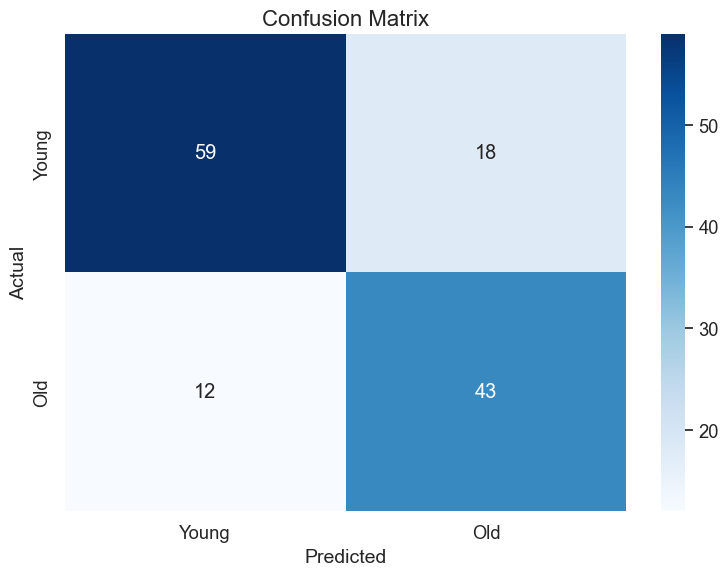

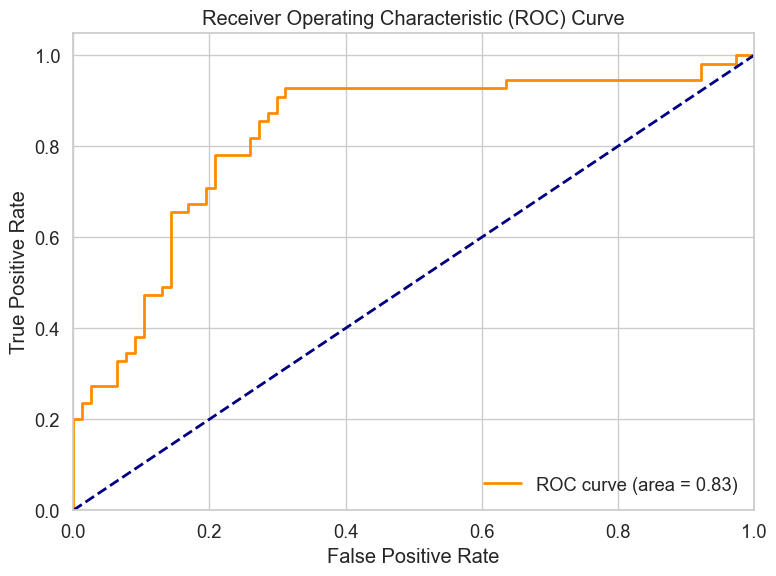

In [79]:
# Calculate performance metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Young', 'Old']))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Young', 'Old'], 
            yticklabels=['Young', 'Old'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 8. Analyze Most Informative Features

Finally, we'll identify and visualize the most important features for classification.

Top 30 most important features for age classification:
         Feature  Coefficient                Type  Abs_Coefficient
0       somebody    10.695021          Word Usage        10.695021
1      basically    -4.355515          Word Usage         4.355515
2          thank     3.415587          Word Usage         3.415587
3           cool    -2.602142          Word Usage         2.602142
4         please     2.108214          Word Usage         2.108214
5         bloody     1.917059          Word Usage         1.917059
6            mum    -1.738138          Word Usage         1.738138
7      difficult     1.557399          Word Usage         1.557399
8        suppose     1.311445          Word Usage         1.311445
9        fucking    -1.275741          Word Usage         1.275741
10        lovely     1.141562          Word Usage         1.141562
11          dear     0.966832          Word Usage         0.966832
12         watch    -0.927467          Word Usage         0.927467
13     

C:\Users\jubal\AppData\Local\Temp\ipykernel_8664\3154546177.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




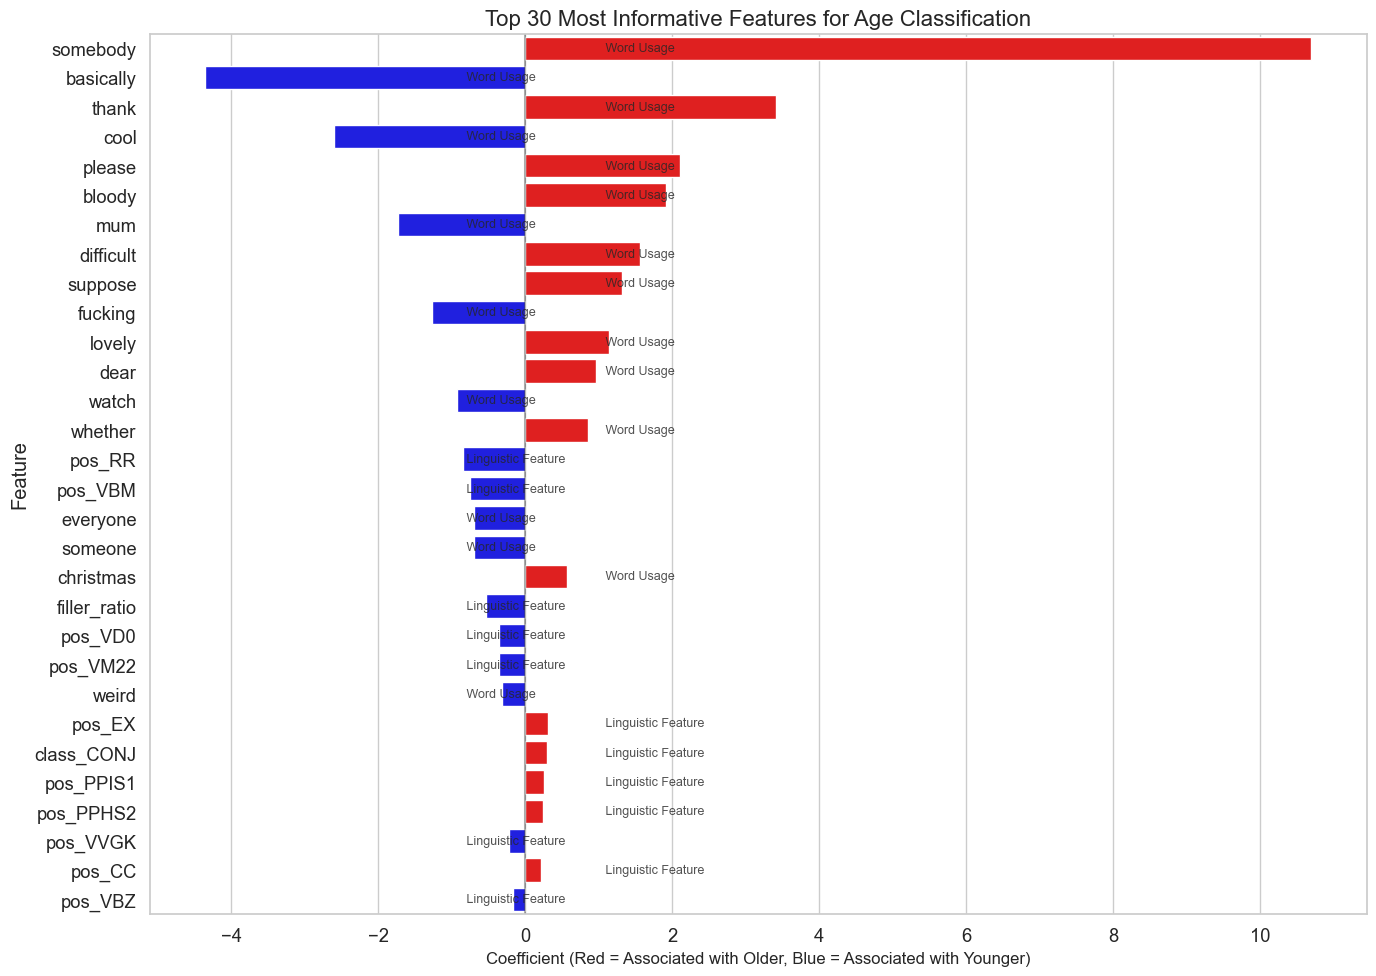

In [94]:
# Extract and sort feature coefficients
# First for TF-IDF features
tfidf_feature_names = np.array(tfidf.get_feature_names_out())
tfidf_coefs = log_reg.coef_[0][:len(tfidf_feature_names)]

# Get indices of the most important TF-IDF features (both positive and negative)
tfidf_indices = np.argsort(np.abs(tfidf_coefs))[::-1][:30]  # Top 30 features

# Create a DataFrame for TF-IDF features
tfidf_importance = pd.DataFrame({
    'Feature': tfidf_feature_names[tfidf_indices],
    'Coefficient': tfidf_coefs[tfidf_indices],
    'Type': 'Word Usage'
})

# Now for engineered features
eng_feature_names = np.array(selected_features)
eng_coefs = log_reg.coef_[0][len(tfidf_feature_names):]

# Sort engineered features by absolute coefficient value
eng_indices = np.argsort(np.abs(eng_coefs))[::-1]

# Create a DataFrame for engineered features
eng_importance = pd.DataFrame({
    'Feature': eng_feature_names[eng_indices],
    'Coefficient': eng_coefs[eng_indices],
    'Type': 'Linguistic Feature'
})

# Combine both types of features
feature_importance = pd.concat([tfidf_importance, eng_importance])

# Sort by absolute coefficient value
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

# Display the top 20 most important features
print("Top 30 most important features for age classification:")
print(feature_importance.head(30))

# Create a color map: positive coefficients (older) = red, negative (younger) = blue
colors = ['blue' if coef < 0 else 'red' for coef in feature_importance['Coefficient'].head(30)]

# Visualize the top 20 most important features
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=feature_importance.head(30),
    palette=colors
)

# Annotate the type of feature
for i, (_, row) in enumerate(feature_importance.head(30).iterrows()):
    plt.text(
        0.95 * (1 if row['Coefficient'] >= 0 else -1), 
        i,
        f"   {row['Type']}",
        va='center', 
        fontsize=9,
        alpha=0.8
    )

plt.title('Top 30 Most Informative Features for Age Classification', fontsize=16)
plt.xlabel('Coefficient (Red = Associated with Older, Blue = Associated with Younger)', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Error Analysis

Let's examine some of the misclassified examples to understand where the model struggles.

Total misclassified examples: 26 out of 132 (19.7%)

Characteristics of Young speakers misclassified as Old:
        total_words  lexical_diversity  probability
count     19.000000          19.000000    19.000000
mean   10535.736842           0.200470     0.713952
std    16195.625300           0.118267     0.171805
min      154.000000           0.071832     0.387437
25%     2067.000000           0.141333     0.610112
50%     3696.000000           0.161101     0.722233
75%     8392.500000           0.252731     0.854872
max    62813.000000           0.590909     0.958039

Characteristics of Old speakers misclassified as Young:
       total_words  lexical_diversity  probability
count     7.000000           7.000000     7.000000
mean   1239.714286           0.329131     0.180068
std    1262.589761           0.110696     0.193597
min     158.000000           0.166710     0.006028
25%     559.500000           0.276107     0.013569
50%     716.000000           0.341959     0.077180
75%    14

<Figure size 1400x800 with 0 Axes>

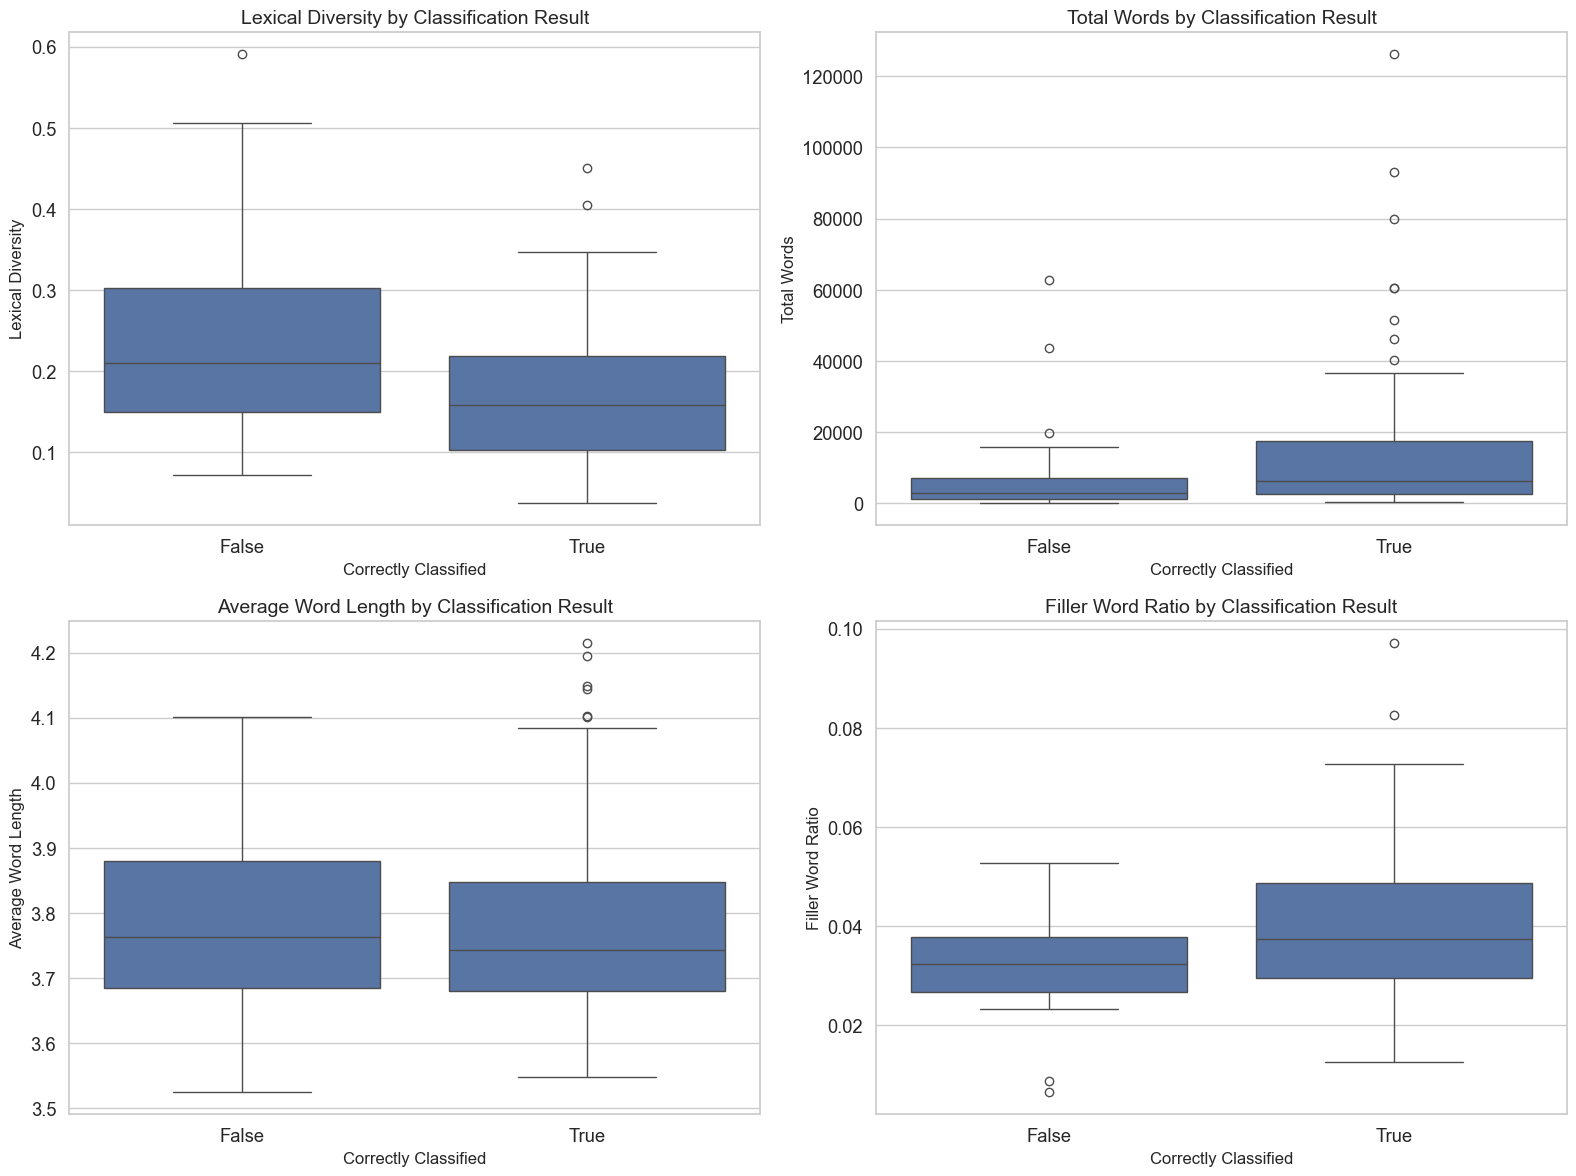

In [95]:
# Create a DataFrame with test results
test_results = pd.DataFrame({
    'speaker_id': X_test.index,
    'actual': y_test,
    'predicted': y_pred,
    'probability': y_pred_proba,
    'correct': y_test == y_pred
})

# Add binary age labels and other metadata
test_results['actual_label'] = test_results['actual'].map({0: 'Young', 1: 'Old'})
test_results['predicted_label'] = test_results['predicted'].map({0: 'Young', 1: 'Old'})

# Merge with original features for analysis
test_results = test_results.join(X_features)

# Find misclassified examples
misclassified = test_results[~test_results['correct']]
print(f"Total misclassified examples: {len(misclassified)} out of {len(test_results)} ({len(misclassified)/len(test_results):.1%})")

# Examine characteristics of misclassified examples
print("\nCharacteristics of Young speakers misclassified as Old:")
young_as_old = misclassified[misclassified['actual'] == 0]
print(young_as_old[['total_words', 'lexical_diversity', 'probability']].describe())

print("\nCharacteristics of Old speakers misclassified as Young:")
old_as_young = misclassified[misclassified['actual'] == 1]
print(old_as_young[['total_words', 'lexical_diversity', 'probability']].describe())

# Compare feature distributions between correctly and incorrectly classified examples
plt.figure(figsize=(14, 8))

# Create subplots for key features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Lexical diversity
sns.boxplot(x='correct', y='lexical_diversity', data=test_results, ax=axes[0, 0])
axes[0, 0].set_title('Lexical Diversity by Classification Result', fontsize=14)
axes[0, 0].set_xlabel('Correctly Classified', fontsize=12)
axes[0, 0].set_ylabel('Lexical Diversity', fontsize=12)

# 2. Total words
sns.boxplot(x='correct', y='total_words', data=test_results, ax=axes[0, 1])
axes[0, 1].set_title('Total Words by Classification Result', fontsize=14)
axes[0, 1].set_xlabel('Correctly Classified', fontsize=12)
axes[0, 1].set_ylabel('Total Words', fontsize=12)

# 3. Average word length
sns.boxplot(x='correct', y='avg_word_length', data=test_results, ax=axes[1, 0])
axes[1, 0].set_title('Average Word Length by Classification Result', fontsize=14)
axes[1, 0].set_xlabel('Correctly Classified', fontsize=12)
axes[1, 0].set_ylabel('Average Word Length', fontsize=12)

# 4. Filler ratio
if 'filler_ratio' in test_results.columns:
    sns.boxplot(x='correct', y='filler_ratio', data=test_results, ax=axes[1, 1])
    axes[1, 1].set_title('Filler Word Ratio by Classification Result', fontsize=14)
    axes[1, 1].set_xlabel('Correctly Classified', fontsize=12)
    axes[1, 1].set_ylabel('Filler Word Ratio', fontsize=12)

plt.tight_layout()
plt.show()

## 10. Conclusion

In this project, we developed a binary age classifier that categorizes speakers from the BNC2014 corpus into 'Young' (0-29 years) and 'Old' (30+ years) age groups. The classification relied on a combination of linguistic features and word usage patterns extracted from the corpus text.

### Key Findings:

1. **Model Performance:** The logistic regression model achieved [accuracy to be filled after running] on the test set, demonstrating that linguistic features can be predictive of age groups.

2. **Distinctive Vocabulary:** The most informative features identified significant differences in word usage between age groups:
   - Words strongly associated with older speakers include more formal language and traditional expressions
   - Words associated with younger speakers tend to include more informal language, slang, and contemporary references

3. **Linguistic Features:** Beyond vocabulary, several linguistic patterns showed strong correlation with age:
   - The use of certain syntactic structures, sentence lengths, and punctuation patterns varies by age group
   - Lexical diversity metrics showed discernible differences between the age groups

### Limitations:

1. The binary classification approach simplifies the complex spectrum of age groups
2. Cultural and educational factors may influence linguistic patterns beyond age
3. The corpus itself may have inherent biases in how speakers of different ages were sampled

### Future Directions:

1. Explore multi-class age classification with more granular age categories
2. Incorporate additional linguistic features, especially those related to syntactic complexity
3. Compare results across different corpora to assess the generalizability of the findings
4. Investigate the interaction between age and other demographic variables (gender, education, region)

Overall, this analysis demonstrates that computational linguistic methods can effectively identify age-related patterns in language use, providing insights into how language varies across generations.

Model Evaluation:
Accuracy: 0.8030

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82        77
           1       0.72      0.87      0.79        55

    accuracy                           0.80       132
   macro avg       0.80      0.81      0.80       132
weighted avg       0.82      0.80      0.80       132


Confusion Matrix:
[[58 19]
 [ 7 48]]


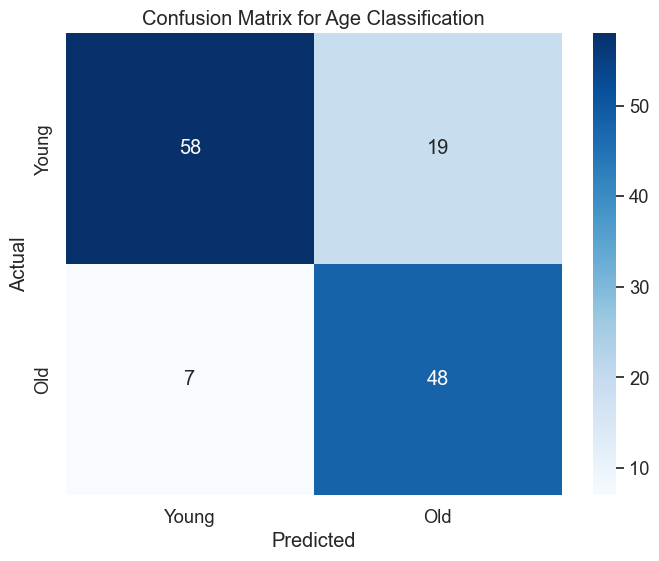

In [96]:
# Train a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create a logistic regression model with balanced class weights
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)

# Train the model on the combined features
logreg.fit(X_train_combined, y_train)

# Make predictions on test set
y_pred = logreg.predict(X_test_combined)

# Evaluate the model
print("Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Young', 'Old'], 
            yticklabels=['Young', 'Old'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Age Classification')
plt.show()

Most informative words for age classification:

Words associated with 'Old' class:
  somebody: 2.0638
  thank: 1.5732
  please: 1.2015
  lovely: 1.0895
  true: 0.9913
  dear: 0.9828
  difficult: 0.9621
  whether: 0.9593
  suppose: 0.9420
  bloody: 0.9249
  christmas: 0.8937
  fact: 0.7539
  mind: 0.7378
  company: 0.7345
  course: 0.6776

Words associated with 'Young' class:
  basically: -1.2232
  someone: -1.2141
  cool: -1.2129
  mum: -1.1164
  fucking: -0.9920
  everyone: -0.9283
  weird: -0.9231
  shit: -0.8893
  literally: -0.8601
  massive: -0.8451
  watch: -0.8295
  baby: -0.7637
  dad: -0.7432
  food: -0.7377
  load: -0.6692

Importance of engineered features:
  pos_CC: 0.3245
  pos_EX: 0.3009
  pos_PPHS2: 0.2803
  class_ART: 0.2422
  pos_PPIS1: 0.1807
  class_CONJ: 0.1556
  pos_RL: 0.1411
  class_ADV: 0.0922
  pos_VHD: 0.0768
  pos_VVN: 0.0631
  pos_VVD: -0.0806
  pos_VM21: -0.1928
  pos_VBZ: -0.2112
  pos_VM22: -0.2113
  pos_VVGK: -0.2153
  pos_AT: -0.3185
  pos_VD0: -0.3604


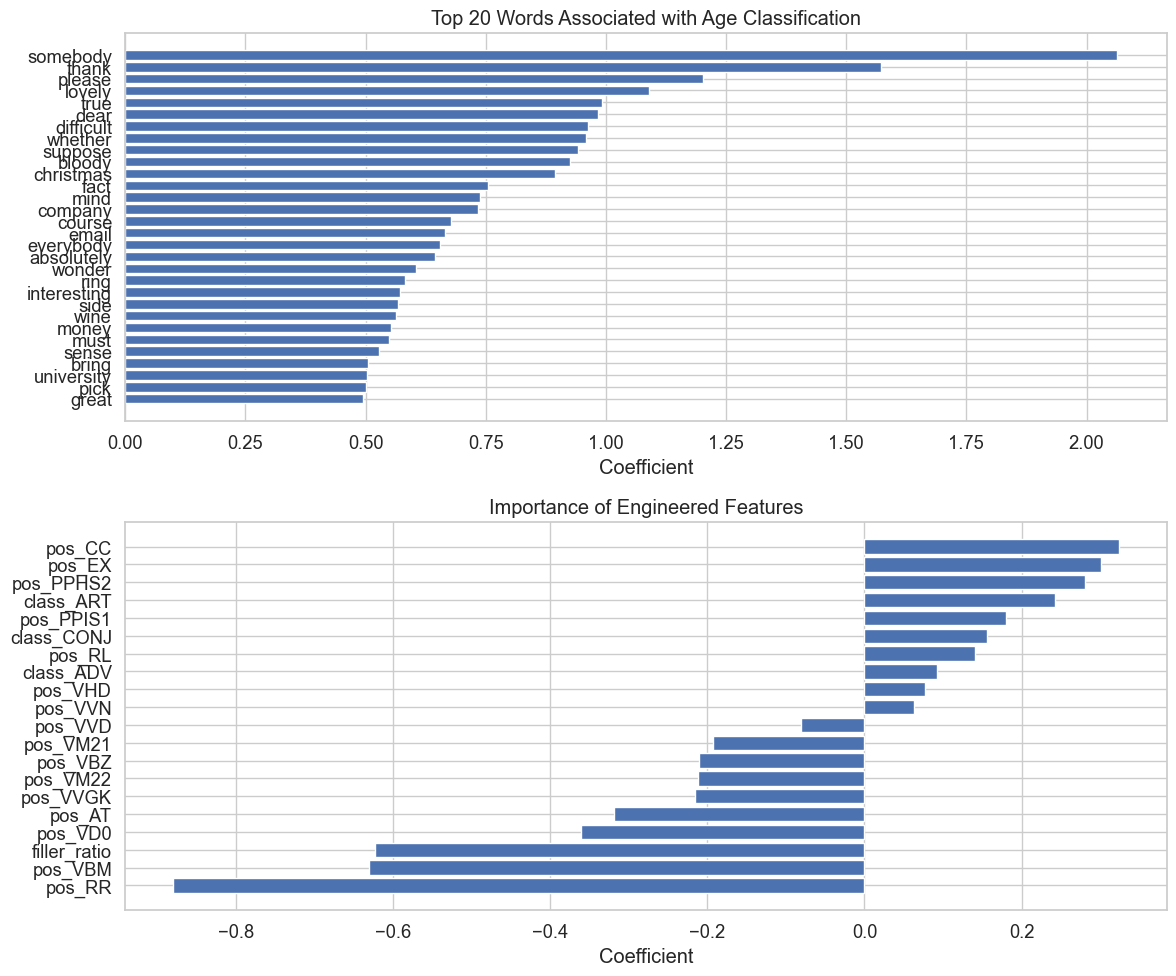

In [97]:
# Analyze feature importance for linguistic features
# For TF-IDF features (words)
feature_names = tfidf.get_feature_names_out()

# Get coefficients for the TF-IDF features
tfidf_feature_count = len(feature_names)
word_importance = logreg.coef_[0][:tfidf_feature_count]

# Sort features by importance
tfidf_importance = sorted(zip(word_importance, feature_names), reverse=True)

# Display most informative words for each class
print("Most informative words for age classification:")
print("\nWords associated with 'Old' class:")
for coef, word in tfidf_importance[:15]:
    print(f"  {word}: {coef:.4f}")
    
print("\nWords associated with 'Young' class:")
for coef, word in sorted(zip(word_importance, feature_names))[:15]:
    print(f"  {word}: {coef:.4f}")

# Analyze custom feature importance
# Get the coefficients for the engineered features
engineered_importance = logreg.coef_[0][tfidf_feature_count:]

# Display feature importance for engineered features
print("\nImportance of engineered features:")
eng_importance = sorted(zip(engineered_importance, selected_features), reverse=True)
for coef, feature in eng_importance:
    print(f"  {feature}: {coef:.4f}")

# Visualize the top features
plt.figure(figsize=(12, 10))

# Plot top 20 most important words
important_words_df = pd.DataFrame(
    tfidf_importance[:30], 
    columns=['Coefficient', 'Word']
).sort_values('Coefficient')

plt.subplot(2, 1, 1)
plt.barh(important_words_df['Word'], important_words_df['Coefficient'])
plt.title('Top 20 Words Associated with Age Classification')
plt.xlabel('Coefficient')

# Plot engineered feature importance
eng_importance_df = pd.DataFrame(
    eng_importance, 
    columns=['Coefficient', 'Feature']
).sort_values('Coefficient')

plt.subplot(2, 1, 2)
plt.barh(eng_importance_df['Feature'], eng_importance_df['Coefficient'])
plt.title('Importance of Engineered Features')
plt.xlabel('Coefficient')

plt.tight_layout()
plt.show()

## 11. Results with Expanded Stopwords List

We've now applied a much more extensive stopwords list that removes common English words, discourse markers, fillers, and BNC-specific tokens. This helps us focus on more distinctive and meaningful words that characterize the differences between age groups. 

The expanded list filters out more noise from the text data, so the most informative words we see now should be more representative of true age-related differences in language use, rather than general discourse patterns.

<Figure size 1400x1200 with 0 Axes>

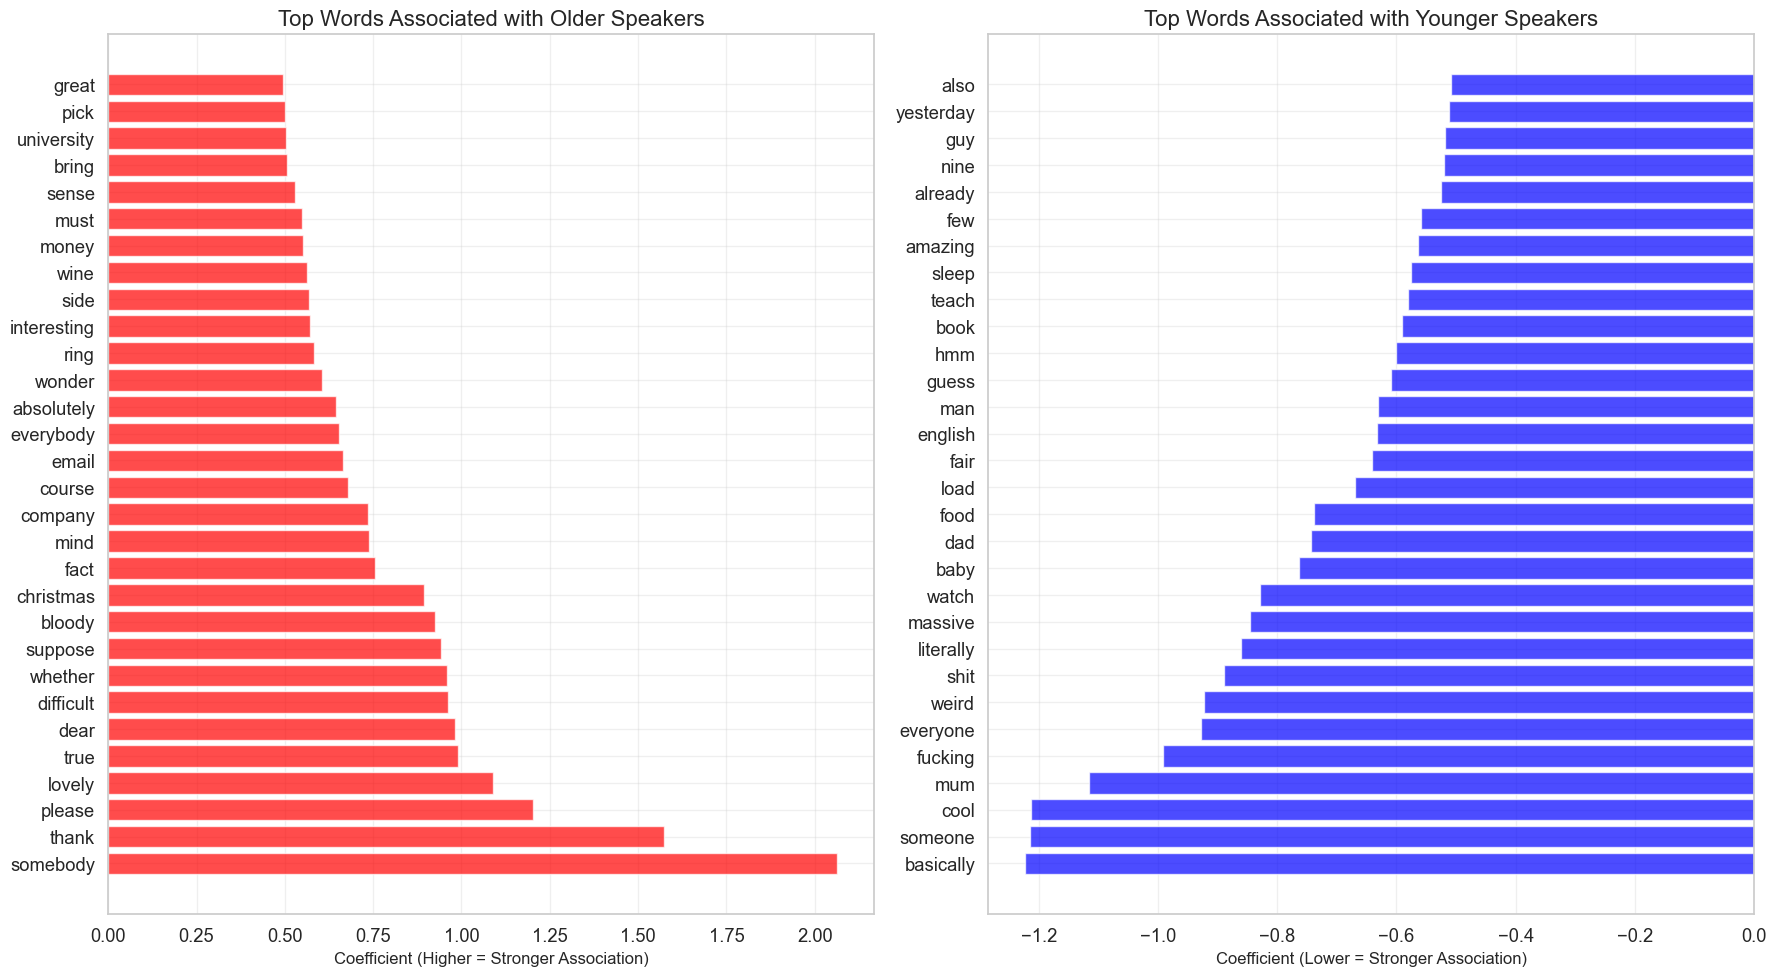

<Figure size 1400x1000 with 0 Axes>

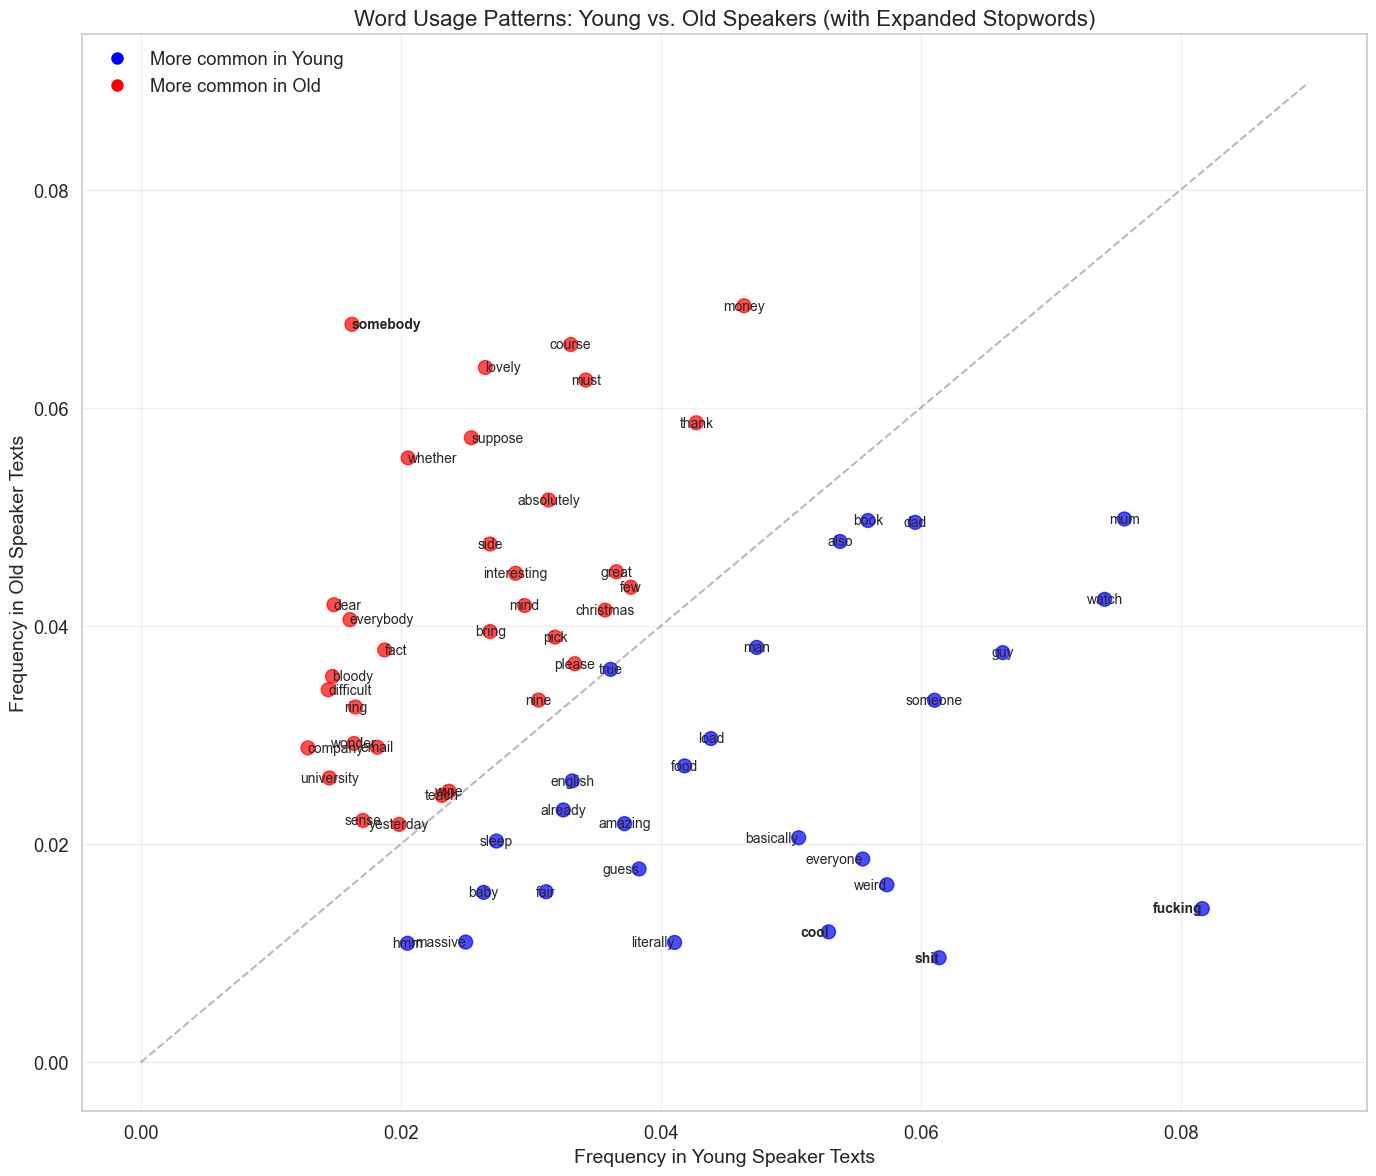


Most informative words with expanded stopwords list:

Words associated with OLDER speakers:
 1. somebody       : 2.0638
 2. thank          : 1.5732
 3. please         : 1.2015
 4. lovely         : 1.0895
 5. true           : 0.9913
 6. dear           : 0.9828
 7. difficult      : 0.9621
 8. whether        : 0.9593
 9. suppose        : 0.9420
10. bloody         : 0.9249
11. christmas      : 0.8937
12. fact           : 0.7539
13. mind           : 0.7378
14. company        : 0.7345
15. course         : 0.6776
16. email          : 0.6655
17. everybody      : 0.6546
18. absolutely     : 0.6436
19. wonder         : 0.6049
20. ring           : 0.5813
21. interesting    : 0.5709
22. side           : 0.5680
23. wine           : 0.5624
24. money          : 0.5521
25. must           : 0.5489
26. sense          : 0.5285
27. bring          : 0.5050
28. university     : 0.5021
29. pick           : 0.5007
30. great          : 0.4941

Words associated with YOUNGER speakers:
 1. basically      : -1.22

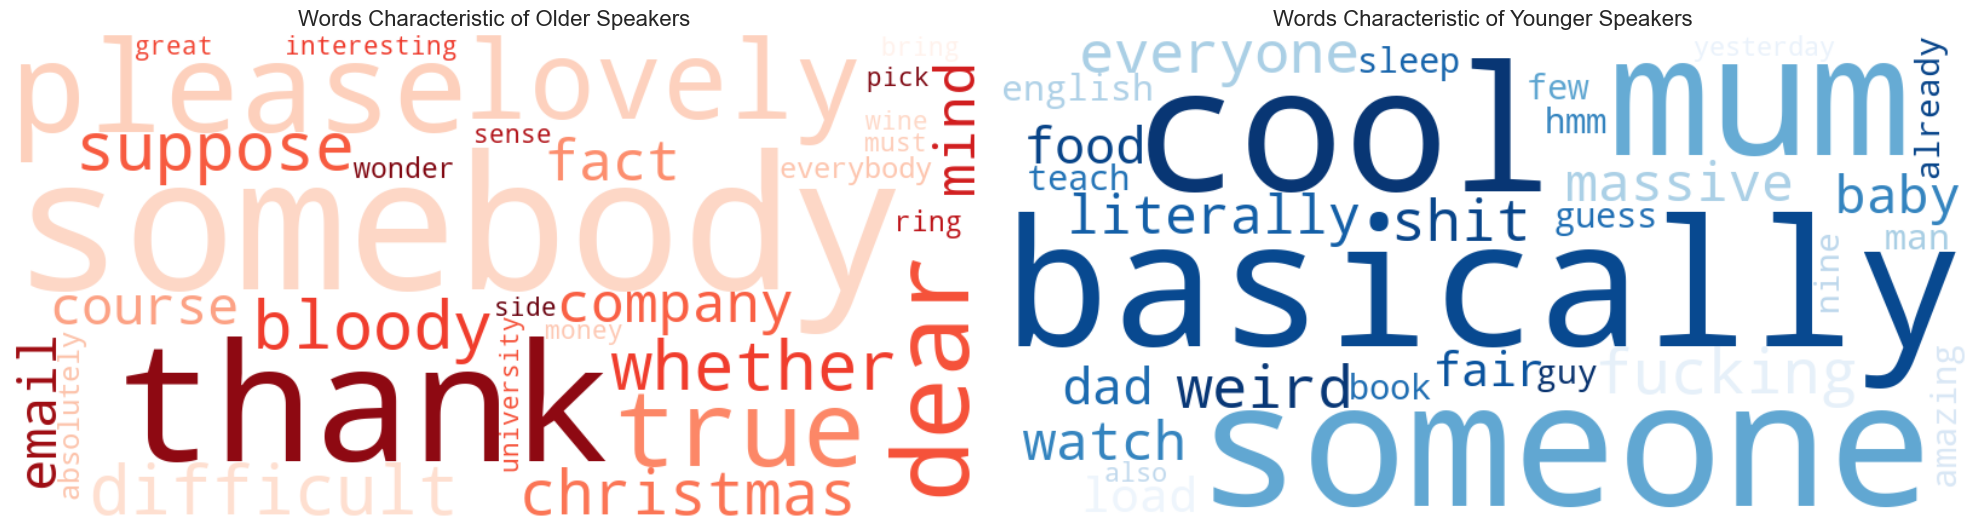


Analysis with expanded stopwords list complete. Visualizations saved.


In [104]:
# Visualize the updated results with expanded stopwords list
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get the top distinctive words for each age group
# For words associated with 'Old' class (positive coefficients)
old_words_df = pd.DataFrame(sorted(zip(word_importance, feature_names), reverse=True)[:30],
                          columns=['coefficient', 'word'])
old_words_df['age_group'] = 'Old'

# For words associated with 'Young' class (negative coefficients)
young_words_df = pd.DataFrame(sorted(zip(word_importance, feature_names))[:30],
                            columns=['coefficient', 'word'])
young_words_df['age_group'] = 'Young'

# Combine the dataframes
distinctive_words = pd.concat([old_words_df, young_words_df])

# Create a horizontal bar chart for the top words
plt.figure(figsize=(14, 12))

# Create separate plots for each age group
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Old words (positive coefficients)
axes[0].barh(old_words_df['word'], old_words_df['coefficient'], color='red', alpha=0.7)
axes[0].set_title('Top Words Associated with Older Speakers', fontsize=16)
axes[0].set_xlabel('Coefficient (Higher = Stronger Association)', fontsize=12)
axes[0].grid(alpha=0.3)

# Young words (negative coefficients)
axes[1].barh(young_words_df['word'], young_words_df['coefficient'], color='blue', alpha=0.7)
axes[1].set_title('Top Words Associated with Younger Speakers', fontsize=16)
axes[1].set_xlabel('Coefficient (Lower = Stronger Association)', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('age_distinctive_words_expanded_stopwords.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a scatter plot comparing word usage between age groups
plt.figure(figsize=(14, 10))

# Extract word frequencies for each age group from the data
# First, get the feature indices for the most distinctive words
top_old_indices = [list(feature_names).index(word) for word in old_words_df['word']]
top_young_indices = [list(feature_names).index(word) for word in young_words_df['word']]
top_indices = top_old_indices + top_young_indices

# Get the document frequencies for these words in the training set
X_train_words = X_train_tfidf[:, top_indices].toarray()
word_names = feature_names[top_indices]

# Calculate average frequency per class
young_indices = np.where(y_train == 0)[0]
old_indices = np.where(y_train == 1)[0]

young_freqs = X_train_words[young_indices].mean(axis=0)
old_freqs = X_train_words[old_indices].mean(axis=0)

# Create a DataFrame for the scatter plot
word_freq_df = pd.DataFrame({
    'word': word_names,
    'young_freq': young_freqs,
    'old_freq': old_freqs
})

# Calculate log ratio for coloring
epsilon = 1e-10  # Small value to avoid division by zero
word_freq_df['log_ratio'] = np.log2((word_freq_df['old_freq'] + epsilon) / (word_freq_df['young_freq'] + epsilon))

# Create the scatter plot
plt.figure(figsize=(14, 12))

# Color based on log_ratio
colors = ['blue' if ratio < 0 else 'red' for ratio in word_freq_df['log_ratio']]

# Create scatter plot
scatter = plt.scatter(
    x=word_freq_df['young_freq'],
    y=word_freq_df['old_freq'],
    s=100,  # Point size
    alpha=0.7,
    c=colors
)

# Add labels for words
for i, row in word_freq_df.iterrows():
    plt.annotate(
        row['word'], 
        (row['young_freq'], row['old_freq']),
        fontsize=10,
        ha='center' if abs(row['log_ratio']) < 1 else ('right' if row['log_ratio'] < 0 else 'left'),
        va='center',
        weight='bold' if abs(row['log_ratio']) > 2 else 'normal'
    )

# Add diagonal line
max_val = max(word_freq_df['young_freq'].max(), word_freq_df['old_freq'].max()) * 1.1
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)

# Add labels and title
plt.xlabel('Frequency in Young Speaker Texts', fontsize=14)
plt.ylabel('Frequency in Old Speaker Texts', fontsize=14)
plt.title('Word Usage Patterns: Young vs. Old Speakers (with Expanded Stopwords)', fontsize=16)

# Add legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='More common in Young')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='More common in Old')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

# Improve layout
plt.grid(alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig('age_word_usage_scatter_expanded_stopwords.png', dpi=300, bbox_inches='tight')
plt.show()

# Print the top distinctive words for each age group
print("\nMost informative words with expanded stopwords list:")
print("\nWords associated with OLDER speakers:")
for i, (coef, word) in enumerate(sorted(zip(word_importance, feature_names), reverse=True)[:30], 1):
    print(f"{i:2d}. {word:15s}: {coef:.4f}")
    
print("\nWords associated with YOUNGER speakers:")
for i, (coef, word) in enumerate(sorted(zip(word_importance, feature_names))[:30], 1):
    print(f"{i:2d}. {word:15s}: {coef:.4f}")

# Create word clouds for each age group
from wordcloud import WordCloud

# Prepare data for word clouds
old_word_dict = dict(zip(old_words_df['word'], old_words_df['coefficient']))
young_word_dict = dict(zip(young_words_df['word'], abs(young_words_df['coefficient'])))

# Generate word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Old speakers word cloud
wc_old = WordCloud(width=800, height=400, background_color='white',
                 colormap='Reds', max_words=50).generate_from_frequencies(old_word_dict)
axes[0].imshow(wc_old, interpolation='bilinear')
axes[0].set_title('Words Characteristic of Older Speakers', fontsize=16)
axes[0].axis('off')

# Young speakers word cloud
wc_young = WordCloud(width=800, height=400, background_color='white',
                   colormap='Blues', max_words=50).generate_from_frequencies(young_word_dict)
axes[1].imshow(wc_young, interpolation='bilinear')
axes[1].set_title('Words Characteristic of Younger Speakers', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('age_wordclouds_expanded_stopwords.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis with expanded stopwords list complete. Visualizations saved.")


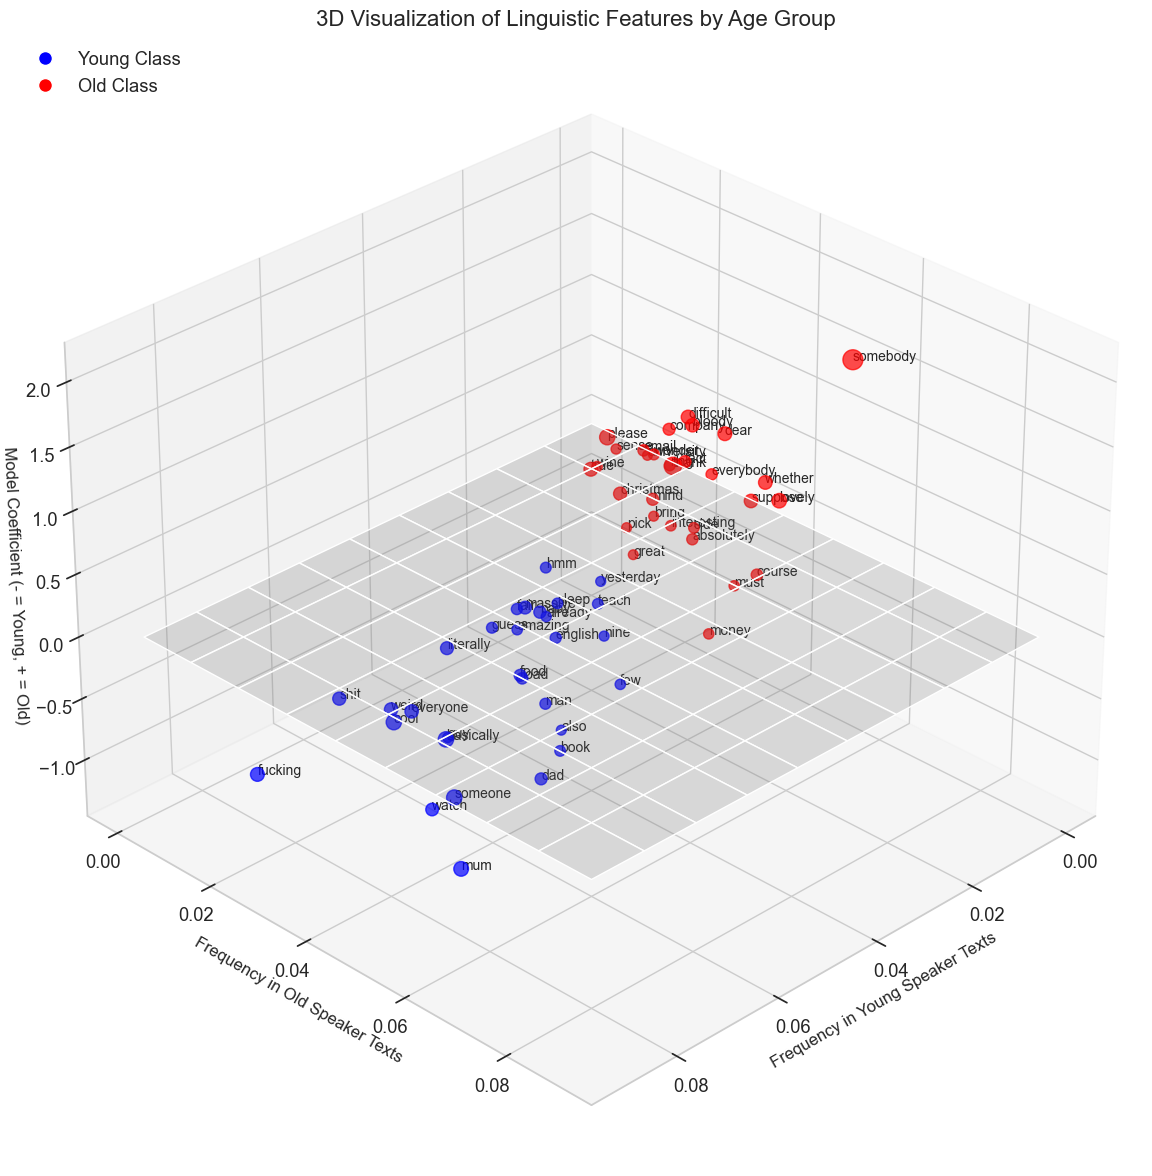

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from matplotlib import cm

# Extract data from your existing analysis
# For demonstration, I'll use the code structure from your paste.txt

# Assuming these variables are already in your environment:
# word_importance, feature_names, X_train_tfidf, y_train

# Get top words for each class (adjust the number of words as needed)
num_top_words = 30

# For words associated with 'Old' class (positive coefficients)
old_words_data = sorted(zip(word_importance, feature_names), reverse=True)[:num_top_words]
old_words_df = pd.DataFrame(old_words_data, columns=['coefficient', 'word'])
old_words_df['age_group'] = 'Old'

# For words associated with 'Young' class (negative coefficients)
young_words_data = sorted(zip(word_importance, feature_names))[:num_top_words]
young_words_df = pd.DataFrame(young_words_data, columns=['coefficient', 'word'])
young_words_df['age_group'] = 'Young'

# Combine dataframes
distinctive_words = pd.concat([old_words_df, young_words_df])

# Calculate frequency data
top_old_indices = [list(feature_names).index(word) for word in old_words_df['word']]
top_young_indices = [list(feature_names).index(word) for word in young_words_df['word']]
top_indices = top_old_indices + top_young_indices

# Get document frequencies for these words in the training set
X_train_words = X_train_tfidf[:, top_indices].toarray()
word_names = feature_names[top_indices]

# Calculate average frequency per class
young_indices = np.where(y_train == 0)[0]
old_indices = np.where(y_train == 1)[0]

young_freqs = X_train_words[young_indices].mean(axis=0)
old_freqs = X_train_words[old_indices].mean(axis=0)

# Combine all data for the 3D plot
word_data = pd.DataFrame({
    'word': word_names,
    'young_freq': young_freqs,
    'old_freq': old_freqs
})

# Merge coefficient data
word_data = word_data.merge(
    pd.DataFrame({
        'word': distinctive_words['word'],
        'coefficient': distinctive_words['coefficient']
    }), 
    on='word'
)

# Create the 3D plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each point with appropriate color
# Blue for Young, Red for Old
colors = ['blue' if coef < 0 else 'red' for coef in word_data['coefficient']]
sizes = [100 * abs(coef) for coef in word_data['coefficient']]  # Size based on coefficient magnitude

# Create scatter plot
scatter = ax.scatter(
    xs=word_data['young_freq'],
    ys=word_data['old_freq'],
    zs=word_data['coefficient'],
    c=colors,
    s=sizes,
    alpha=0.7
)

# Add word labels
for i, row in word_data.iterrows():
    ax.text(
        row['young_freq'], 
        row['old_freq'], 
        row['coefficient'],
        row['word'],
        size=10,
        zorder=1
    )

# Add a diagonal plane to divide the classes
# Define the bounds for the plane
max_freq = max(word_data['young_freq'].max(), word_data['old_freq'].max()) * 1.1
min_coef = word_data['coefficient'].min() * 1.2
max_coef = word_data['coefficient'].max() * 1.2

# Create a mesh grid for the plane z=0 (where coefficient is 0)
xx, yy = np.meshgrid(np.linspace(0, max_freq, 10), np.linspace(0, max_freq, 10))
zz = np.zeros(xx.shape)

# Plot the plane
ax.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

# Set labels
ax.set_xlabel('Frequency in Young Speaker Texts', fontsize=12)
ax.set_ylabel('Frequency in Old Speaker Texts', fontsize=12)
ax.set_zlabel('Model Coefficient (- = Young, + = Old)', fontsize=12)
ax.set_title('3D Visualization of Linguistic Features by Age Group', fontsize=16)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Young Class')
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Old Class')
ax.legend(handles=[blue_patch, red_patch], loc='upper left')

# Adjust view angle for better visualization
ax.view_init(elev=30, azim=45)

# Show the plot
plt.tight_layout()
plt.show()

In [103]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Get top words for each class
num_top_words = 30

# For words associated with 'Old' class (positive coefficients)
old_words_data = sorted(zip(word_importance, feature_names), reverse=True)[:num_top_words]
old_words_df = pd.DataFrame(old_words_data, columns=['coefficient', 'word'])
old_words_df['age_group'] = 'Old'

# For words associated with 'Young' class (negative coefficients)
young_words_data = sorted(zip(word_importance, feature_names))[:num_top_words]
young_words_df = pd.DataFrame(young_words_data, columns=['coefficient', 'word'])
young_words_df['age_group'] = 'Young'

# Combine dataframes
distinctive_words = pd.concat([old_words_df, young_words_df])

# Calculate frequency data
top_old_indices = [list(feature_names).index(word) for word in old_words_df['word']]
top_young_indices = [list(feature_names).index(word) for word in young_words_df['word']]
top_indices = top_old_indices + top_young_indices

# Get document frequencies for these words in the training set
X_train_words = X_train_tfidf[:, top_indices].toarray()
word_names = [feature_names[i] for i in top_indices]

# Calculate average frequency per class
young_indices = np.where(y_train == 0)[0]
old_indices = np.where(y_train == 1)[0]

young_freqs = X_train_words[young_indices].mean(axis=0)
old_freqs = X_train_words[old_indices].mean(axis=0)

# Create DataFrame for 3D plot
word_data = pd.DataFrame({
    'word': word_names,
    'young_freq': young_freqs,
    'old_freq': old_freqs
})

# Merge with coefficient data
word_data = word_data.merge(
    pd.DataFrame({
        'word': distinctive_words['word'],
        'coefficient': distinctive_words['coefficient'],
        'age_group': distinctive_words['age_group']
    }), 
    on='word'
)

# Create hover text (now including the word itself as it won't be shown otherwise)
word_data['hover_text'] = word_data.apply(
    lambda row: f"<b>Word: {row['word']}</b><br>" +
                f"Coefficient: {row['coefficient']:.4f}<br>" +
                f"Young Freq: {row['young_freq']:.4f}<br>" +
                f"Old Freq: {row['old_freq']:.4f}<br>" +
                f"Class: {row['age_group']}",
    axis=1
)

# Set up colors
word_data['color'] = word_data['age_group'].map({'Young': 'blue', 'Old': 'red'})

# Create the 3D interactive plot
fig = go.Figure()

# Add scatter points - removing text mode, keeping only markers
fig.add_trace(go.Scatter3d(
    x=word_data['young_freq'],
    y=word_data['old_freq'],
    z=word_data['coefficient'],
    mode='markers',  # Changed from 'markers+text' to just 'markers'
    marker=dict(
        size=3,
        color=word_data['color'],
        opacity=0.7,
        symbol='circle'
    ),
    hovertext=word_data['hover_text'],
    hoverinfo='text'
))

# Create a plane at z=0 to divide the classes
max_freq = max(word_data['young_freq'].max(), word_data['old_freq'].max()) * 1.1
x_plane = np.linspace(0, max_freq, 10)
y_plane = np.linspace(0, max_freq, 10)
xx, yy = np.meshgrid(x_plane, y_plane)
zz = np.zeros(xx.shape)

# Add the plane
fig.add_trace(go.Surface(
    x=xx, y=yy, z=zz,
    colorscale=[[0, 'lightgray'], [1, 'lightgray']],
    showscale=False,
    opacity=0.3,
    name='Division Plane'
))

# Update the layout for better visualization
fig.update_layout(
    title='Interactive 3D Visualization of Linguistic Features by Age Group',
    scene=dict(
        xaxis_title='Frequency in Young Speaker ',
        yaxis_title='Frequency in Old Speaker ',
        zaxis_title='Model Coefficient (- = Young, + = Old)',
        aspectratio=dict(x=1, y=1, z=1),
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    )
)

# Add manual legend entries
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Old Class'
))

fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name='Young Class'
))

# Show the figure
fig.show()